In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import zuko

_ = torch.random.manual_seed(0)

In [3]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(16384)

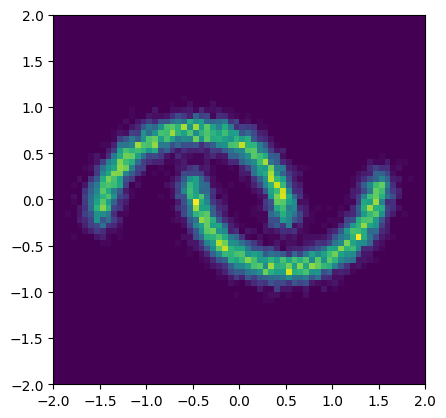

In [4]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [5]:
trainset = data.TensorDataset(*two_moons(16384))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))
flow

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

In [11]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for epoch in range(1):
    losses = []

    for x, label in trainloader:
        c = label.unsqueeze(dim=-1)
        print(c.shape, x.shape)
        loss = -flow(c).log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])
torch.Size([64, 1]) torch.Size([64, 2])


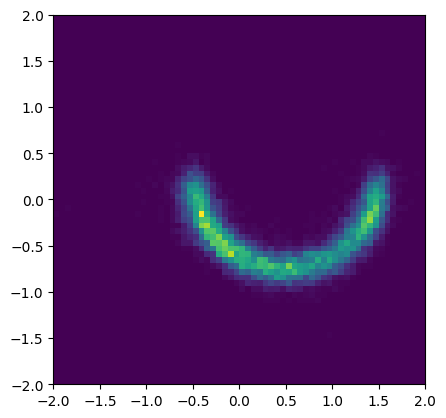

In [10]:
samples = flow(torch.tensor([1.0])).sample((16384,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()